# Review Visual Genome Faster R-CNN Training

Check images, labels, and predictions.

### 1. Setup

* First, set up Python, `numpy`, and `matplotlib`.

In [1]:
# set up Python environment: numpy for numerical routines, and matplotlib for plotting
import numpy as np
import matplotlib.pyplot as plt
import pylab
from skimage import transform
# display plots in this notebook
%matplotlib inline

import os

# set display defaults
plt.rcParams['figure.figsize'] = (12, 9)        # small images
plt.rcParams['image.interpolation'] = 'nearest'  # don't interpolate: show square pixels
plt.rcParams['image.cmap'] = 'gray'  # use grayscale output rather than a (potentially misleading) color heatmap

* Load `caffe`.

In [2]:
# Change dir to caffe root or prototxt database paths won't work wrong
import os
print os.getcwd()
os.chdir('..')
print os.getcwd()

/home/chenlong/workspace/test/bottom-up-attention/tools
/home/chenlong/workspace/test/bottom-up-attention


In [3]:
# The caffe module needs to be on the Python path;
#  we'll add it here explicitly.
import sys
sys.path.insert(0, './caffe/python/')
sys.path.insert(0, './lib/')
sys.path.insert(0, './tools/')

import caffe
from fast_rcnn.train import get_training_roidb, filter_roidb, SolverWrapper
from fast_rcnn.config import cfg, cfg_from_file, cfg_from_list, get_output_dir
from datasets.factory import get_imdb
from train_net import combined_roidb
# If you get "No module named _caffe", either you have not built pycaffe or you have the wrong path.

imagenet_train
<function <lambda> at 0x7f53e0eaf7d0>
imagenet_val
<function <lambda> at 0x7f53e0eafaa0>


In [4]:
data_path = './data/genome/1600-400-20'

# Load classes
classes = ['__background__']
with open(os.path.join(data_path, 'objects_vocab.txt')) as f:
    for object in f.readlines():
        classes.append(object.split(',')[0].lower().strip())

# Load attributes
attributes = ['__no_attribute__']
with open(os.path.join(data_path, 'attributes_vocab.txt')) as f:
    for att in f.readlines():
        attributes.append(att.split(',')[0].lower().strip())

# Load relations
relations = ['__no_relation__']
with open(os.path.join(data_path, 'relations_vocab.txt')) as f:
    for rel in f.readlines():
        relations.append(rel.split(',')[0].lower().strip()) 

### 2. Review Training Data

* Check that the training images and labels make sense.

In [7]:
# Load a model and run one solver step

GPU_ID = 1   # if we have multiple GPUs, pick one
caffe.set_device(GPU_ID)  
caffe.set_mode_gpu()
net = None

cfg_from_file('experiments/cfgs/faster_rcnn_end2end_resnet.yml')

imdb, roidb = combined_roidb('vg_1600-400-20_minitrain')
print '{:d} roidb entries'.format(len(roidb))

output_dir = get_output_dir(imdb)
print 'Output will be saved to `{:s}`'.format(output_dir)

roidb = filter_roidb(roidb)

pretrained_model = 'data/faster_rcnn_models/resnet101_faster_rcnn_final.caffemodel'
sw = SolverWrapper('models/vg/ResNet-101/faster_rcnn_end2end_final/solver.prototxt', 
                       roidb, output_dir,
                       pretrained_model=pretrained_model)

100%|██████████| 1000/1000 [00:10<00:00, 95.58it/s]


Loaded dataset `vg_1600-400-20_minitrain` for training
Set proposal method: gt
Appending horizontally-flipped training examples...
wrote gt roidb to /home/chenlong/workspace/test/bottom-up-attention/data/cache/vg_1600-400-20_minitrain_gt_roidb.pkl
done
Preparing training data...


  4%|▍         | 39/1000 [00:00<00:02, 387.15it/s]

done


100%|██████████| 1000/1000 [00:02<00:00, 443.43it/s]


1986 roidb entries
Output will be saved to `/home/chenlong/workspace/test/bottom-up-attention/output/faster_rcnn_resnet/vg_1600-400-20_minitrain`
Filtered 0 roidb entries: 1986 -> 1986
Computing bounding-box regression targets...
bbox target means:
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 ...
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
[0. 0. 0. 0.]
bbox target stdevs:
[[0.1 0.1 0.2 0.2]
 [0.1 0.1 0.2 0.2]
 [0.1 0.1 0.2 0.2]
 ...
 [0.1 0.1 0.2 0.2]
 [0.1 0.1 0.2 0.2]
 [0.1 0.1 0.2 0.2]]
[0.1 0.1 0.2 0.2]
Normalizing targets
done
RoiDataLayer: name_to_top: {'gt_boxes': 2, 'data': 0, 'im_info': 1}
Loading pretrained model weights from data/faster_rcnn_models/resnet101_faster_rcnn_final.caffemodel


In [8]:
# create transformer for the input called 'data'
def get_transformer(net):
    transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})
    transformer.set_transpose('data', (2,0,1))  # move image channels to outermost dimension
    transformer.set_channel_swap('data', (2,1,0))  # swap channels from RGB to BGR
    transformer.set_raw_scale('data', 255)      # rescale from [0, 1] to [0, 255]
    transformer.set_mean('data', np.array([103,116,123])) # subtract the dataset-mean value in each channel
    return transformer

tr = get_transformer(sw.solver.net)

In [32]:
sw.solver.step(1)

In [46]:
sw.solver.net.blobs['data'].data.shape

(1, 3, 800, 600)

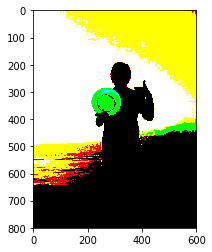

In [47]:
plt.imshow(sw.solver.net.blobs['data'].data[0].transpose(1, 2, 0))

[[[390.4]]

 [[108.8]]

 [[411.2]]

 [[134.4]]]
moon

> <ipython-input-45-aa0cf6afc7df>(19)<module>()
-> plt.gca().add_patch(
(Pdb) q


BdbQuit: 

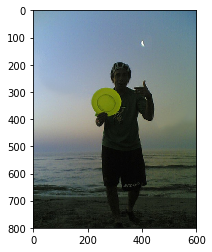

In [45]:
# Show object and attribute training data
im = tr.deprocess('data', sw.solver.net.blobs['data'].data[0])
plt.imshow(im)

im_info = sw.solver.net.blobs['im_info'].data
gt_boxes = sw.solver.net.blobs['gt_boxes'].data

# gt_boxes contains 0:3 - bounding box, 4 - object class, 5: - attribute classes

for i,row in enumerate(gt_boxes):
#     import pdb; pdb.set_trace()
    bbox = row[0:4]
    object_cls = classes[int(row[4])]
    attribute_cls = ",".join([attributes[int(a)] for a in row[5:] if int(a) > 0])
    print bbox
    print object_cls
    print attribute_cls
    import pdb; pdb.set_trace()
    plt.gca().add_patch(
        plt.Rectangle((bbox[0], bbox[1]),
                      bbox[2] - bbox[0],
                      bbox[3] - bbox[1], fill=False,
                      edgecolor='red', linewidth=1)
            )
    plt.gca().text(bbox[0], bbox[1] - 2,
                '{} {:s} {:s}'.format(i,attribute_cls,object_cls),
                bbox=dict(facecolor='blue', alpha=0.5),
                fontsize=8, color='white')     

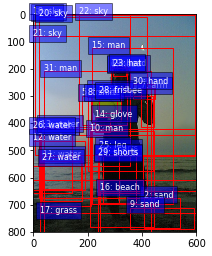

In [35]:
# Check argmax object predictions
rois = sw.solver.net.blobs['rois'].data
cls = sw.solver.net.blobs['foreground_labels'].data
cls_score = sw.solver.net.blobs['cls_score'].data
pred_cls = np.argmax(cls_score[:,1:], axis=1)

plt.imshow(im)

max_boxes = 32
for i in range(0,min(max_boxes,rois.shape[0])):
    bbox = rois[i][1:5]
    plt.gca().add_patch(
        plt.Rectangle((bbox[0], bbox[1]),
                      bbox[2] - bbox[0],
                      bbox[3] - bbox[1], fill=False,
                      edgecolor='red', linewidth=1)
            )
    plt.gca().text(bbox[0], bbox[1] - 2,
                '{}: {:s}'.format(i,classes[int(pred_cls[i])+1]),
                bbox=dict(facecolor='blue', alpha=0.5),
                fontsize=8, color='white') 

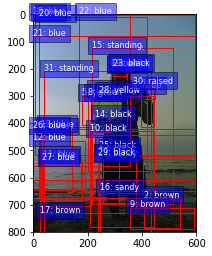

In [36]:
# Check argmax attribute predictions
rois = sw.solver.net.blobs['rois'].data
attr_score = sw.solver.net.blobs['attr_score'].data
attr = np.argmax(attr_score[:,1:], axis=1)

plt.imshow(im)

for i in range(rois.shape[0]/2):
    bbox = rois[i][1:5]
    plt.gca().add_patch(
        plt.Rectangle((bbox[0], bbox[1]),
                      bbox[2] - bbox[0],
                      bbox[3] - bbox[1], fill=False,
                      edgecolor='red', linewidth=1)
            )
    plt.gca().text(bbox[0], bbox[1] - 2,
                '{}: {:s}'.format(i,attributes[int(attr[i])+1]),
                bbox=dict(facecolor='blue', alpha=0.5),
                fontsize=8, color='white') 